### **Libraries & dataset**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
import albumentations as A
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import jaccard_score
import warnings
warnings.filterwarnings("ignore")

INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.5 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
2025-03-25 15:48:35.265030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742917715.286269 2119042 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742917715.291545 2119042 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class Config:
    img_size=(256,256)
    batch_size=4
    epochs=10
    learning_rate=1e-4

config=Config()

In [3]:
name_data_image_path_cvc300="../data/CVC-300/images"
name_data_mask_path_cvc300="../data/CVC-300/masks"

data_image_cvc300=sorted(os.listdir(name_data_image_path_cvc300))
data_mask_cvc300=sorted(os.listdir(name_data_mask_path_cvc300))

In [4]:
data_images_combined = [os.path.join(name_data_image_path_cvc300, img) for img in data_image_cvc300]
data_masks_combined = [os.path.join(name_data_mask_path_cvc300, mask) for mask in data_mask_cvc300]
  
len(data_images_combined),len(data_masks_combined)

(60, 60)

In [5]:
train_transform = A.Compose([
    A.Resize(*config.img_size),
    A.Rotate(limit=15, p=0.2), 
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),  
    A.Normalize(mean=(0,0,0), std=(1,1,1), max_pixel_value=255)
])

val_transform=A.Compose([
    A.Resize(*config.img_size),
    A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255)
])

In [6]:
class Dataset(keras.utils.Sequence):
    def __init__(self, img_list, mask_list, transform, batch_size=4):
        self.img_list = img_list  # Full path
        self.mask_list = mask_list
        self.transform = transform
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.img_list) / self.batch_size))
        
    def __getitem__(self, index):
        batch_img_paths = self.img_list[index * self.batch_size : (index + 1) * self.batch_size]
        batch_mask_paths = self.mask_list[index * self.batch_size : (index + 1) * self.batch_size]

        images, masks = [], []
        for img_path, mask_path in zip(batch_img_paths, batch_mask_paths):
            img = Image.open(img_path).convert("RGB")  
            mask = Image.open(mask_path).convert("L")

            mask = np.array(mask) / 255.0
            mask[mask > 0.5] = 1

            augmented = self.transform(image=np.array(img), mask=mask)
            images.append(augmented["image"])
            masks.append(np.expand_dims(augmented["mask"], axis=-1))

        return np.array(images), np.array(masks)


In [7]:
test_dataset = Dataset(data_images_combined, data_masks_combined, val_transform)

In [8]:
print("Number of images in test set:", len(data_images_combined))
print("Length of test_dataset (batches):", len(test_dataset))

Number of images in test set: 60
Length of test_dataset (batches): 15


### **Load model**

In [ ]:
path_model="../models/best_dc-unet_model.h5"
model=load_model(path_model)
# model.summary()

2025-03-25 15:48:37.703370: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### **Evaluating perrformance on CVC-300 dataset**

##### **1. Mean Absolute Error (MAE)**
**Purpose**: Measures pixel-wise intensity difference between two grayscale images.  

**Formula**:  
$$
MAE(A, B) = 1 - \frac{|A - B|}{\text{maxE}}
$$  
where $ \text{maxE} = W \times L \times 2^8 $ for an 8-bit grayscale image of size $ W \times L $.  

**Interpretation:**  
- A value close to 1 indicates high similarity between the two images.  

**Pros:** Simple, directly measures intensity differences on a pixel-by-pixel basis.  

**Cons:** Does not explicitly account for spatial structure, only per-pixel intensity differences.


##### **2. Dice Coefficient (DC)**  
**Purpose**: Measures the similarity between two **binary** images. 

**Formula**:  
$$
DC(A, B) = \frac{2 |A \cap B|}{|A| + |B|}
$$  

**Variables:**  
- $ A, B $: Binary images treated as sets.  
- $ |A \cap B| $: Number of pixels (or elements) in the intersection.  
- $ |A|, |B| $: Number of pixels in each set.  

**Interpretation:**  
- Value range: $ 0 \leq DC \leq 1 $.  
- Higher DC $\rightarrow$ More overlap (better segmentation).  
- $DC = 1$ $\rightarrow$ Perfect overlap.  

**Pros:**  
- More sensitive to small segmentation errors than Jaccard Similarity.  
- Frequently used in medical image segmentation.  

**Cons:**  
- Like JS, it does not capture structural differences.  

##### **3. Jaccard Similarity (JS)**
**Purpose**: Measures overlap between two **binary** images.  
**Formula**:  
$$
JS(A, B) = \frac{|A \cap B|}{|A \cup B|}
$$  
**Variables:**  
- $ A, B $: Binary images treated as sets.  
- $ |A \cap B| $: Number of pixels (or elements) in the intersection.  
- $ |A \cup B| $: Number of pixels in the union.  

**Interpretation:**  
- Value range: $ 0 \leq JS \leq 1 $.  
- Higher JS $\rightarrow$ More overlap (better segmentation).  
- JS = 1 $\rightarrow$ Perfect overlap.  

##### **4. Tanimoto Similarity**  
A generalized form of Jaccard Similarity, adapt for grayscale images.

**Formula**:  
$$
T(A, B) = \frac{\sum a_i b_i}{\sum (a_i^2 + b_i^2 - a_i b_i)}
$$  

**Advantages:**  
- Preserves grayscale information without thresholding.  
- Stable with respect to image size and object area ratio changes.  
- Often yields results close to JS when images are binary.  

**Limitations:**  
- Computationally more involved compared to standard Jaccard Similarity.

##### **5. Structural Similarity (SSIM)**
- **Definition**: Evaluates the perceptual similarity between two images by comparing their luminance, contrast, and structural patterns.
- **Interpretation**: SSIM close to 1 means the two images share similar luminance, contrast, and structure.  
- **Advantages**: Better reflects perceptual quality compared to simple error metrics.  
- **Limitations**: Sensitive to changes in image scale or object size, as noted in the paper.

In [10]:
def compute_metrics(y_true, y_pred):
    # mae_fn = tf.keras.losses.MeanAbsoluteError()
    # mae_value = mae_fn(y_true, y_pred).numpy()
    max_pixel_value = tf.reduce_max(y_true).numpy()  # max(A)
    mae_value = 1 - (tf.reduce_mean(tf.abs(y_true - y_pred)) / max_pixel_value).numpy()

    # Jaccard
    jaccard = jaccard_score(y_true.flatten() > 0.5, y_pred.flatten() > 0.5, average='binary')

    # Dice Coefficient
    intersection = np.sum(y_true * y_pred)
    dice = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-7)

    # Tanimoto Coefficient
    denominator = np.sum(y_true**2) + np.sum(y_pred**2) - intersection
    tanimoto = intersection / (denominator + 1e-7)
    
    # SSIM use library
    ssim_value = ssim(y_true.squeeze(), y_pred.squeeze(), data_range=1)
    
    return {
        "MAE": mae_value,
        "Jaccard Index": jaccard,
        "Tanimoto Coefficient": tanimoto,
        "Dice Coefficient": dice, 
        "SSIM": ssim_value
    }

In [11]:
results = []

for i in range(len(test_dataset)):
    x, y_true = test_dataset[i]
    y_pred_batch = (model.predict(x) > 0.5).astype(np.uint8)
  
    for j in range(x.shape[0]):
        metrics = compute_metrics(y_true[j], y_pred_batch[j])
        results.append(metrics)

average_metrics = {key: np.mean([r[key] for r in results]) for key in results[0]}

print("\nMetrics on test dataset")
for metric, value in average_metrics.items():
    print(f"{metric}: {value:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Metrics on test dataset
MAE: 0.9960
Jaccard Index: 0.8583
Tanimoto Coefficient: 0.8583
Dice Coefficient: 0.9201
SSIM: 0.9849


#### **Evaluation Summary**
* **MAE:** 0.9960 -> indicating minimal pixel-wise intensity differences between the segmented output and the ground truth.

* **Jaccard Index & Tanimoto Coefficient:** 0.8583 -> high performance, the segmentation effectively captures the target regions.

* **Dice Coefficient:** 0.9201 -> very high, the segmented areas closely match the ground truth with balanced precision and recall.

* **SSIM:** close to 1 -> the model preserves structural details well, but may still be sensitive to small distortions or boundary differences.

### **Predict each image**

Image shape after fix: (256, 256, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Metrics for this sample:
MAE: 0.9963
Jaccard Index: 0.8536
Tanimoto Coefficient: 0.8536
Dice Coefficient: 0.9210
SSIM: 0.9870


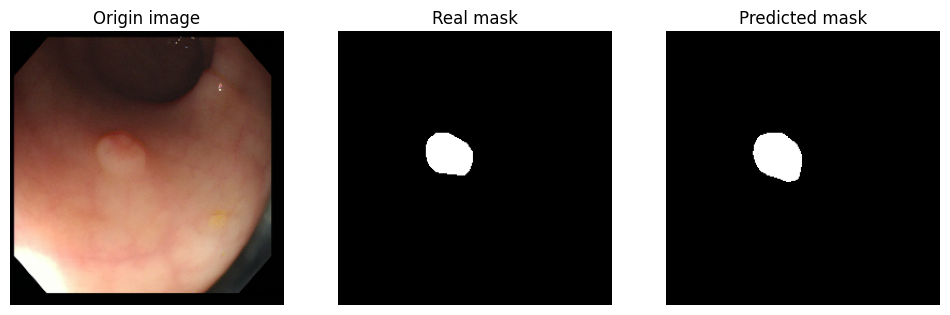

In [ ]:
# Pick random 
sample_index = 2
sample_img, sample_mask = test_dataset[sample_index]  


if len(sample_img.shape) == 4:  
    sample_img = sample_img[3]  
    sample_mask = sample_mask[3]

print(f"Image shape after fix: {sample_img.shape}") 

if sample_img.max() <= 1.0:  
    sample_img_display = (sample_img * 255).astype(np.uint8)  
else:
    sample_img_display = sample_img.astype(np.uint8) 


sample_img_input = np.expand_dims(sample_img, axis=0).astype(np.float32)  

pred_mask = model.predict(sample_img_input)[0]  
pred_mask = np.squeeze(pred_mask) 
pred_mask = (pred_mask > 0.5).astype(np.uint8)  


sample_mask_squeeze = np.squeeze(sample_mask)
pred_mask_squeeze = np.squeeze(pred_mask)
metrics_sample = compute_metrics(sample_mask_squeeze, pred_mask_squeeze)
print("\nMetrics for this sample:")
for metric, value in metrics_sample.items():
    print(f"{metric}: {value:.4f}")


# Draw plotplot
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(sample_img_display)  
plt.title("Origin image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(sample_mask.squeeze(), cmap="gray")  
plt.title("Real mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap="gray")  
plt.title("Predicted mask")
plt.axis("off")

plt.show()